In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from scipy.stats import rv_histogram

import nice
from nice.reload import deep_reload

In [118]:
'''
Geometry
'''

state = gpd.read_file('Data/Geometry/california.shp')
counties = gpd.read_file('Data/Geometry/california_counties.shp')
taz = gpd.read_file('Data/TAZ/CSTDM_v2.0_TAZ.shp')
taz.to_crs(4326, inplace = True)

<Axes: >

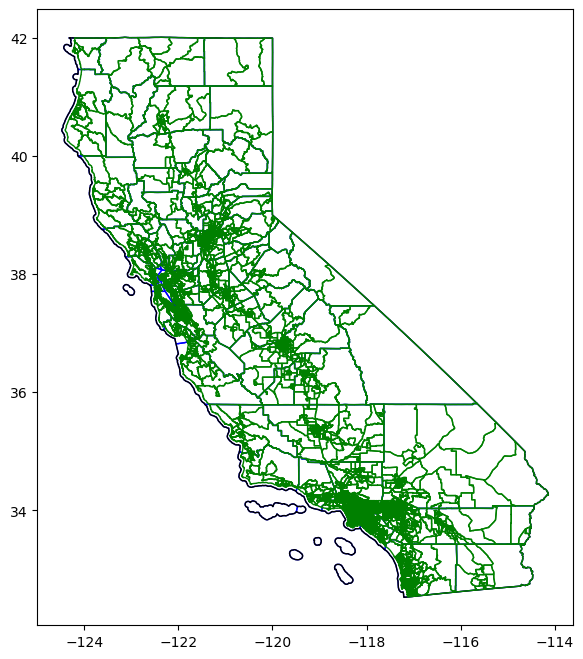

In [120]:
fig, ax = plt.subplots(figsize = (8, 8))

counties.plot(ax = ax, fc = 'none', ec = 'b')
state.plot(ax = ax, fc = 'none', ec = 'k')
taz.plot(ax = ax, fc = 'none', ec = 'g')

In [121]:
taz

,County,TAZ12,Shape_Le_1,Shape_Area,SqMI,NewUniqID,geometry
0,Del Norte,100,38712.709338,2.846238e+07,10.989344,1,"MULTIPOLYGON (((-124.2056 41.80225, -124.2057 ..."
1,Del Norte,101,31480.545738,3.408002e+07,13.158316,2,"POLYGON ((-124.14208 41.76039, -124.14211 41.7..."
2,Del Norte,102,65933.883132,1.032175e+08,39.852333,3,"POLYGON ((-124.16018 41.90903, -124.15922 41.9..."
3,Del Norte,103,208609.582799,1.062543e+09,410.248574,4,"MULTIPOLYGON (((-124.1976 41.93102, -124.19771..."
4,Del Norte,104,257565.262748,1.396731e+09,539.278564,5,"MULTIPOLYGON (((-124.17729 41.74611, -124.1772..."
...,...,...,...,...,...,...,...
5449,Los Angeles,3599,36826.514491,3.918948e+07,15.131081,5620,"POLYGON ((-118.79157 34.81709, -118.78945 34.8..."
5450,Riverside,5450,14123.095367,5.381670e+06,2.077866,5621,"POLYGON ((-117.50848 33.90229, -117.50863 33.9..."
5451,Orange,5797,68296.737996,1.534400e+08,59.243275,5622,"POLYGON ((-117.7473 33.78492, -117.7473 33.785..."
5452,Santa Cruz,3114,51905.328165,5.179285e+07,19.997252,5625,"POLYGON ((-121.84102 37.06506, -121.84116 37.0..."


In [5]:
'''
Data
'''

atlas = nice.graph.graph_from_json('Data/atlas.json')

reduced_atlas = nice.graph.graph_from_json('Data/reduced_atlas.json')

stations = nice.graph.graph_from_json('Data/stations.json')

places = nice.graph.graph_from_json('Data/places_10k.json')

In [33]:
places._node['Los Angeles, CA']

{'x': -118.41133252854276,
 'y': 34.10717493544776,
 'population': 3822782.0,
 'type': 'place'}

In [41]:
'''
Clusering places
'''

kw = {
    'fields': ['time', 'distance'],
}

places = nice.graph.adjacency(reduced_atlas, places, **kw)

 [--------->] (376/376) 100.00%, 18.84 it/s, 20.01 s elapsed, 0.00 s remaining

In [58]:
'''
Clusering places
'''

x = np.array([n['x'] for n in places._node.values()])
y = np.array([n['y'] for n in places._node.values()])
p = np.array([n['population'] for n in places._node.values()])

# x_s, x_t = np.meshgrid(x, x, indexing = 'ij')
# y_s, y_t = np.meshgrid(y, y, indexing = 'ij')
p_s, p_t = np.meshgrid(p, p, indexing = 'ij')

d = np.array(
    [[places._adj[s][t]['time'] for t in places.nodes] for s in places.nodes]
)

# d = nice.utilities.haversine(x_s, y_s, x_t, y_t)
g = p_s * p_t / np.exp(-.75 * d / 3600)
g /= g.max()
g

array([[1.04596160e-06, 1.01468220e-05, 1.15600655e-06, ...,
        1.07891589e-05, 8.72649553e-06, 9.10232534e-05],
       [1.01468220e-05, 2.24957944e-05, 1.03904963e-05, ...,
        7.39277668e-05, 5.97943114e-05, 3.15563401e-04],
       [1.15600655e-06, 1.03904963e-05, 7.38114321e-07, ...,
        1.14303819e-05, 9.24513003e-06, 9.64329621e-05],
       ...,
       [1.07891589e-05, 7.39277668e-05, 1.14303819e-05, ...,
        1.32717981e-06, 1.44781536e-06, 1.94658361e-05],
       [8.72649553e-06, 5.97943114e-05, 9.24513003e-06, ...,
        1.44781536e-06, 1.14112820e-06, 1.74474053e-05],
       [9.10232534e-05, 3.15563401e-04, 9.64329621e-05, ...,
        1.94658361e-05, 1.74474053e-05, 5.01895986e-06]])

In [111]:
# g = p_s * p_t * np.exp(-.75 * d / 3600)
g = np.exp(-.005 * d)

cg = nx.from_numpy_array(g, create_using = nx.DiGraph)

communities = nx.community.louvain_communities(cg, resolution = 1)
print(len(communities))
labels = list(places.nodes)

nodes = []

for idx, community in enumerate(communities):

    x = np.array([places._node[labels[k]]['x'] for k in community])
    y = np.array([places._node[labels[k]]['y'] for k in community])
    p = np.array([places._node[labels[k]]['population'] for k in community])

    nodes.append(
        (idx, {'x': x.mean(), 'y': y.mean(), 'p': p.sum(), 'community': idx})
    )
    
    for k in community:

        places._node[labels[k]]['community'] = idx

ccg = nx.Graph()
ccg.add_nodes_from(nodes)

78


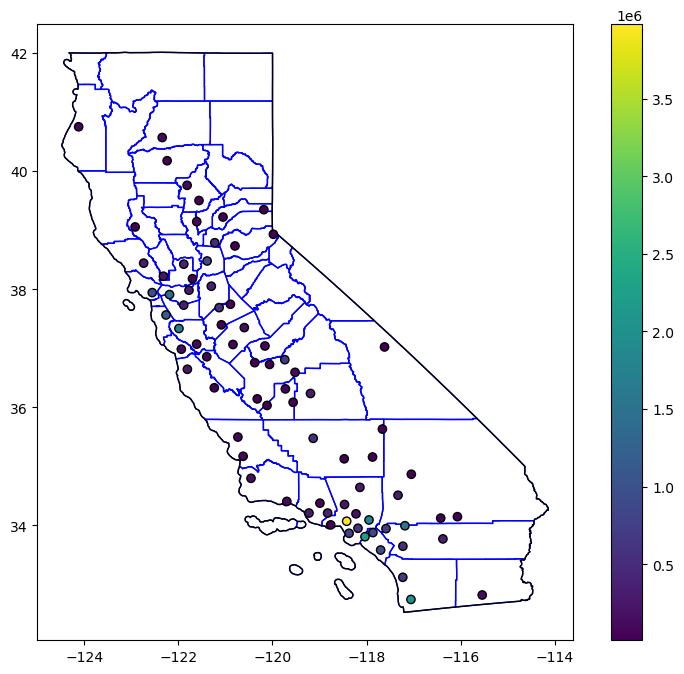

In [114]:
fig, ax = plt.subplots(figsize = (10, 8))

counties.plot(ax = ax, fc = 'none', ec = 'b')
state.plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'field': 'p',
    'plot': {
        'ec': 'k',
        # 'color': 'k',
    },
    'colorbar': {},
}
    
_ = nice.plot.plot_nodes(ccg, ax = ax, **kw)

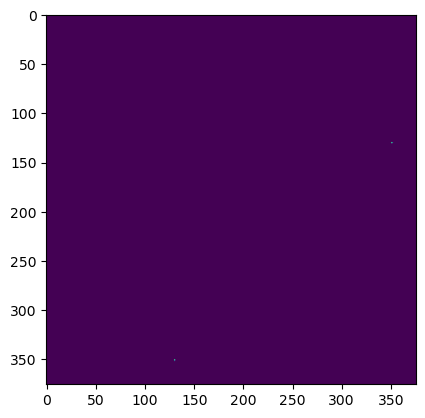

In [116]:
fig, ax = plt.subplots()

g = p_s * p_t / np.exp(-.005 * d)
# g /= g.max()
# g

ax.imshow(g)

In [12]:
reduced_atlas.number_of_nodes(), places.number_of_nodes(), stations.number_of_nodes()

(7634, 376, 3297)

In [16]:
stations._node[list(stations.nodes)[0]]

{'access_code': 'public',
 'access_days_time': '24 hours daily',
 'open_date': '2022-04-16',
 'owner_type_code': None,
 'restricted_access': None,
 'status_code': 'E',
 'funding_sources': None,
 'facility_type': None,
 'station_name': 'Pacifica Foothill Center (Vista, CA)',
 'latitude': 33.21947,
 'longitude': -117.22491,
 'city': 'Vista',
 'country': 'US',
 'state': 'CA',
 'street_address': '1223 E Vista Way',
 'zip': '92084',
 'ev_workplace_charging': False,
 'network': 'Electrify America',
 'charging_level': 'dc_fast',
 'connector': 'J1772COMBO',
 'power_kw': 150.0,
 'port_count': 4,
 'x': -117.22491,
 'y': 33.21947,
 'power': [150000.0, 150000.0, 150000.0, 150000.0],
 'type': 'station'}

In [19]:
np.unique([n['charging_level'] for n in stations._node.values()])

array(['dc_fast'], dtype='<U7')

In [21]:
np.unique([n['power_kw'] for n in stations._node.values()], return_counts = True)

(array([  0. ,  20. ,  23. ,  24. ,  25. ,  30. ,  44. ,  49.9,  50. ,
         51. ,  60. ,  62. ,  62.5,  72. ,  75. ,  80. ,  90. ,  95. ,
        100. , 120. , 125. , 150. , 151. , 175. , 180. , 190. , 200. ,
        201. , 220. , 240. , 250. , 350. , 360. , 400. , 480. ]),
 array([   2,    2,    2,   25,   26,    7,   38,    1, 1262,   13,   35,
         285,  311,    4,    7,    8,   10,    1,  273,   25,    5,  125,
           1,    4,   25,    1,   23,    8,    1,    9,  485,  250,    3,
           1,   19]))

In [22]:
stations_50 = nice.graph.subgraph(
    stations, [k for k, n in stations._node.items() if n['power_kw'] > 50]
)

stations_80 = nice.graph.subgraph(
    stations, [k for k, n in stations._node.items() if n['power_kw'] > 80]
)

stations_50.number_of_nodes(), stations_80.number_of_nodes()

(1932, 1269)

In [26]:
stations_50_ccs = nice.graph.subgraph(
    stations_50,
    [k for k, n in stations_50._node.items() if n['network'] != 'Tesla']
)

stations_50_nacs = nice.graph.subgraph(
    stations_50,
    [k for k, n in stations_50._node.items() if n['network'] == 'Tesla']
)

stations_50_ccs.number_of_nodes(), stations_50_nacs.number_of_nodes()

(1442, 490)

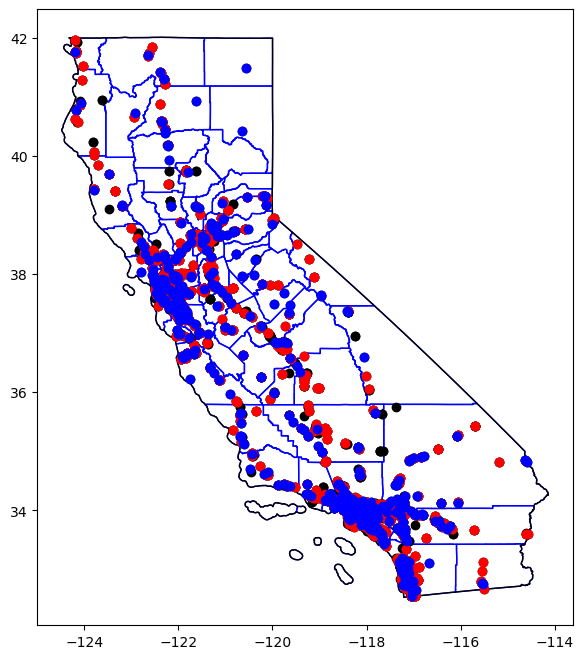

In [29]:
fig, ax = plt.subplots(figsize = (10, 8))

counties.plot(ax = ax, fc = 'none', ec = 'b')
state.plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'plot': {
        'color': 'k',
    },
}
    
_ = nice.plot.plot_nodes(stations, ax = ax, **kw)

kw = {
    'plot': {
        'fc': 'red',
    },
}
    
_ = nice.plot.plot_nodes(stations_50_ccs, ax = ax, **kw)

kw = {
    'plot': {
        'fc': 'blue',
    },
}
    
_ = nice.plot.plot_nodes(stations_50_nacs, ax = ax, **kw)

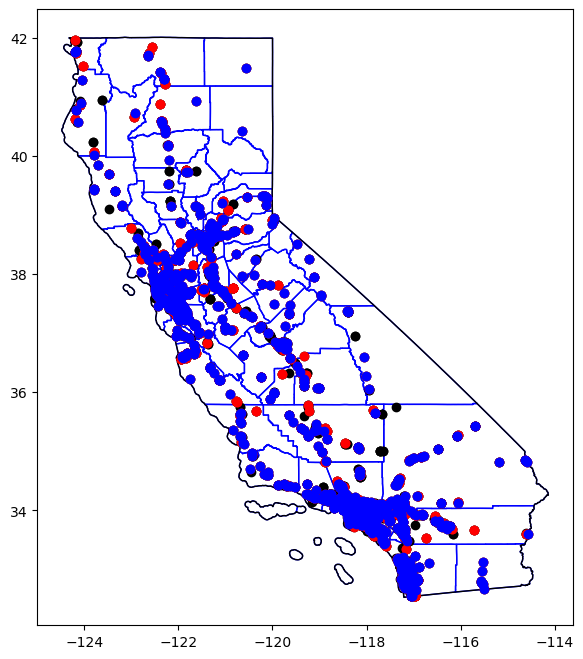

In [30]:
fig, ax = plt.subplots(figsize = (10, 8))

counties.plot(ax = ax, fc = 'none', ec = 'b')
state.plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'plot': {
        'color': 'k',
    },
}
    
_ = nice.plot.plot_nodes(stations, ax = ax, **kw)

kw = {
    'plot': {
        'fc': 'red',
    },
}
    
_ = nice.plot.plot_nodes(stations_50, ax = ax, **kw)

kw = {
    'plot': {
        'fc': 'blue',
    },
}
    
_ = nice.plot.plot_nodes(stations_80, ax = ax, **kw)

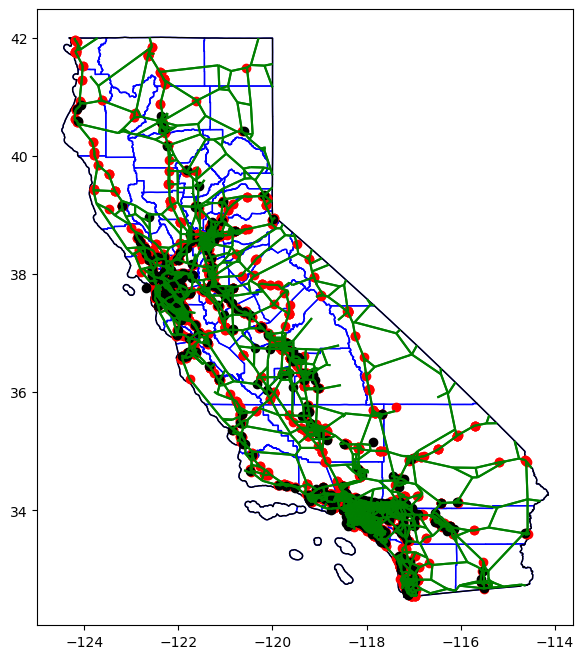

In [9]:
fig, ax = plt.subplots(figsize = (10, 8))

counties.plot(ax = ax, fc = 'none', ec = 'b')
state.plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'plot': {
        'color': 'green',
    },
}
    
_ = nice.plot.plot_edges(reduced_atlas, ax = ax, **kw)

kw = {
    'plot': {
        'fc': 'red',
    },
}
    
_ = nice.plot.plot_nodes(stations, ax = ax, **kw)

kw = {
    'plot': {
        'fc': 'k',
    },
}
    
_ = nice.plot.plot_nodes(places, ax = ax, **kw)